## LLM

In [4]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer, Inference
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load Data

In [5]:
tokenizer = loader("../tokenizers/cnn_tokenizer3.pkl")

## Initialize Model

In [6]:
torch.manual_seed(42)

embed_dim = 64*18
ff_dim = 4*embed_dim
heads = 18
tf_blocks = 18

model = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=tokenizer.token_to_idx["<s>"],
    use_weight_tying=True
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")
loss_train_list = []
loss_test_list = []

num_epochs      = 1
steps_per_epoch = 1
warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

[model, 
optimizer, 
scheduler, 
loss_train_list, 
loss_test_list] = load_checkpoint("../models/checkpoint_transformer_3epoch.pth", 
                                  model, 
                                  optimizer, 
                                  scheduler, 
                                  loss_train_list, 
                                  loss_test_list)

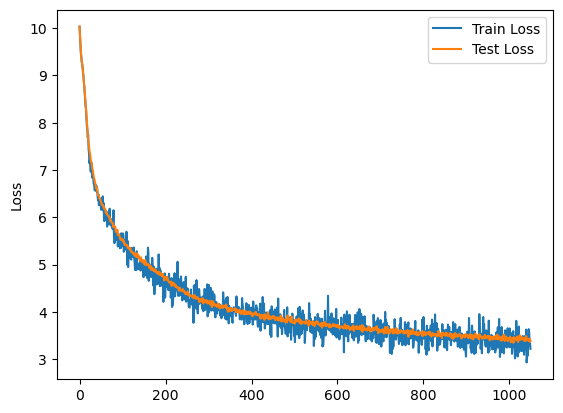

In [7]:
plt.plot(loss_train_list, label='Train Loss')
plt.plot(loss_test_list, label='Test Loss')
plt.ylabel('Loss')
plt.legend()


In [8]:
inference = Inference(model, tokenizer, context_length=1024, device=device)

In [9]:
highlight_list = loader("../corpus/cnn_dailymail_highlight_test_cleaned.pkl")
article_list = loader("../corpus/cnn_dailymail_article_test_cleaned.pkl")

In [27]:
highlight = highlight_list[3]
article = article_list[3]

print(highlight)
print(article)

17 americans were exposed to the ebola virus while in sierra leone in march. another person was diagnosed with the disease and taken to hospital in maryland. national institutes of health says the patient is in fair condition after weeks of treatment.
(cnn)five americans who were monitored for three weeks at an omaha, nebraska, hospital after being exposed to ebola in west africa have been released, a nebraska medicine spokesman said in an email wednesday. one of the five had a heart-related issue on saturday and has been discharged but hasn't left the area, taylor wilson wrote. the others have already gone home. they were exposed to ebola in sierra leone in march, but none developed the deadly virus. they are clinicians for partners in health, a boston-based aid group. they all had contact with a colleague who was diagnosed with the disease and is being treated at the national institutes of health in bethesda, maryland. as of monday, that health care worker is in fair condition. the c

In [28]:
text = "<s><h>" + highlight + "<b>"
#text = "<s><b>" + article + "<h>"

torch.manual_seed(42)
inference.run(text, 
              T = 1, 
              k = 50)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))